In [1]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler
from keras.datasets import mnist
import matplotlib.pyplot as plt

## Reduce the dimensionality of the data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

X_all = np.concatenate([X_train, X_test])
y_all = np.concatenate([y_train, y_test])

In [3]:
rng = np.random.default_rng(547)
labels = np.unique(y_all)
X_bal = []
y_bal = []
for label in labels:
    label_idx = np.argwhere(y_all == label).reshape(-1)
    X_label = X_all[label_idx]
    y_label = y_all[label_idx]
    sample_idx = rng.choice(len(label_idx), size=5000, replace=False)
    X_bal.append(X_label[sample_idx])
    y_bal.append(y_label[sample_idx])
X_bal = np.concatenate(X_bal)
y_bal = np.concatenate(y_bal)

In [4]:
shuffle_idx = rng.choice(len(y_bal), size=len(y_bal), replace=False)
X = X_bal[shuffle_idx].reshape(len(shuffle_idx), -1)
y = y_bal[shuffle_idx]

In [5]:
X = StandardScaler().fit_transform(X)
X = LinearDiscriminantAnalysis().fit_transform(X, y)
X = Normalizer().fit_transform(X)

## Explore-Then-Commit

### Model the world

In [6]:
def ETC_world(tau, X, y, rng):
    T = len(y)
    action_history = np.zeros(T)

    # explore
    actions = rng.choice(10, tau, replace=True)
    action_history[:tau] = actions
    R_tau = (actions == y[:tau]).astype(int)

    C_tau = X[:tau]
    A_tau = np.zeros((tau, 10))
    A_tau[np.arange(tau), actions] = 1
    Phi_tau = np.einsum("ij,ik->ijk", C_tau, A_tau).reshape(tau, -1)

    theta_hat = np.linalg.solve(Phi_tau.T @ Phi_tau, Phi_tau.T @ R_tau)

    # commit
    for t in range(tau, T):
        C_t = np.repeat(X[[t]], repeats=10, axis=0)
        A_t = np.eye(10)
        Phi_t = np.einsum("ij,ik->ijk", C_t, A_t).reshape(10, -1)
        a_t = np.argmax(Phi_t @ theta_hat)
        action_history[t] = a_t

    return action_history

c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


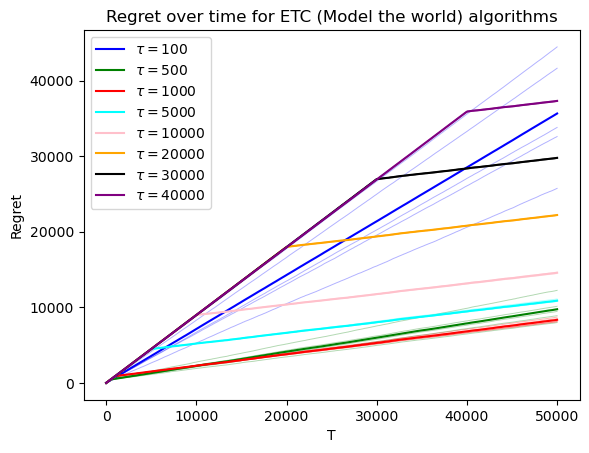

In [7]:
rng = np.random.default_rng(547)

color = ["blue", "green", "red", "cyan", "pink", "orange", "black", "purple"]
tau_range = [100, 500, 1000, 5000, 10000, 20000, 30000, 40000]

fig, ax = plt.subplots()
for i in range(len(tau_range)):
    tau = tau_range[i]
    regrets = []
    for _ in range(5):
        action_history = ETC_world(tau, X.copy(), y.copy(), rng)
        regret = np.cumsum(y != action_history)
        regrets.append(regret)
        ax.plot(range(len(regret)), regret, color=color[i], alpha=0.3, linewidth=0.7)
    regert_avg = np.mean(np.array(regrets), axis=0)
    ax.plot(range(len(regert_avg)), regert_avg, color=color[i], label=rf"$\tau = {tau}$")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for ETC (Model the world) algorithms")
ax.legend()
fig.show()

From the plot above, we should select $\tau = 1000$ ("Model the world").

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


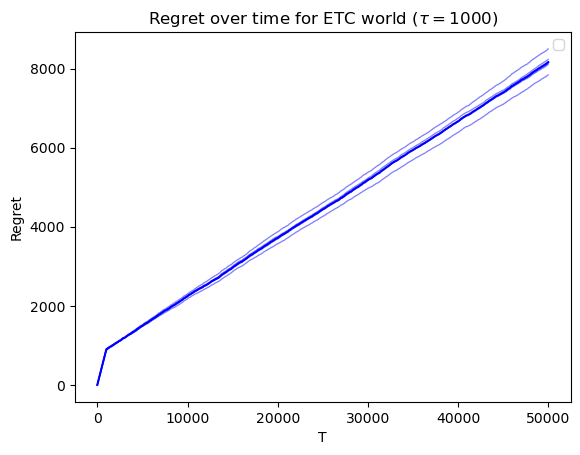

In [8]:
rng = np.random.default_rng(547)
ETC_world_regrets = []
fig, ax = plt.subplots()

for _ in range(5):
    action_history = ETC_world(1000, X.copy(), y.copy(), rng)
    regret = np.cumsum(y != action_history)
    ETC_world_regrets.append(regret)
    ax.plot(range(len(regret)), regret, color="blue", alpha=0.5, linewidth=0.9)
ETC_world_regrets_avg = np.mean(np.array(ETC_world_regrets), axis=0)
ax.plot(range(len(ETC_world_regrets_avg)), ETC_world_regrets_avg, color="blue")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title(r"Regret over time for ETC world ($\tau = 1000$)")
ax.legend()
fig.show()

### Model the bias

In [9]:
from sklearn.linear_model import LogisticRegression

def ETC_bias(tau, X, y, rng):
    T = len(y)
    action_history = np.zeros(T)

    actions = rng.choice(10, tau, replace=True)
    action_history[:tau] = actions
    mask = (actions == y[:tau])
    C_tau = X[:tau][mask]
    A_tau = actions[mask]

    model = LogisticRegression().fit(C_tau, A_tau)

    action_history[tau:] = model.predict(X[tau:])

    return action_history

c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


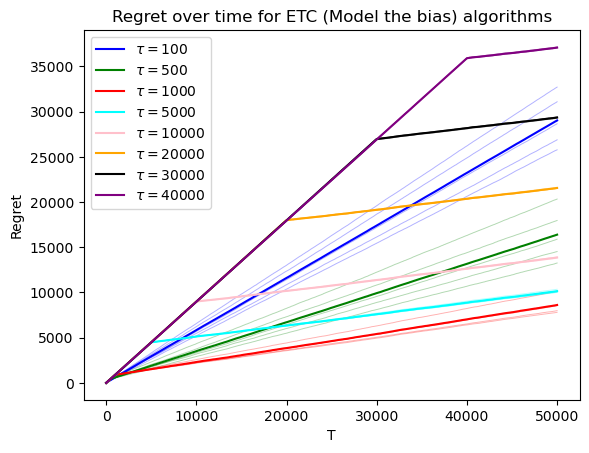

In [10]:
rng = np.random.default_rng(547)

color = ["blue", "green", "red", "cyan", "pink", "orange", "black", "purple"]
tau_range = [100, 500, 1000, 5000, 10000, 20000, 30000, 40000]

fig, ax = plt.subplots()
for i in range(len(tau_range)):
    tau = tau_range[i]
    regrets = []
    for _ in range(5):
        action_history = ETC_bias(tau, X.copy(), y.copy(), rng)
        regret = np.cumsum(y != action_history)
        regrets.append(regret)
        ax.plot(range(len(regret)), regret, color=color[i], alpha=0.3, linewidth=0.7)
    regert_avg = np.mean(np.array(regrets), axis=0)
    ax.plot(range(len(regert_avg)), regert_avg, color=color[i], label=rf"$\tau = {tau}$")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for ETC (Model the bias) algorithms")
ax.legend()
fig.show()

From the plot above, we should select $\tau = 1000$ for ETC ("Model the bias").

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


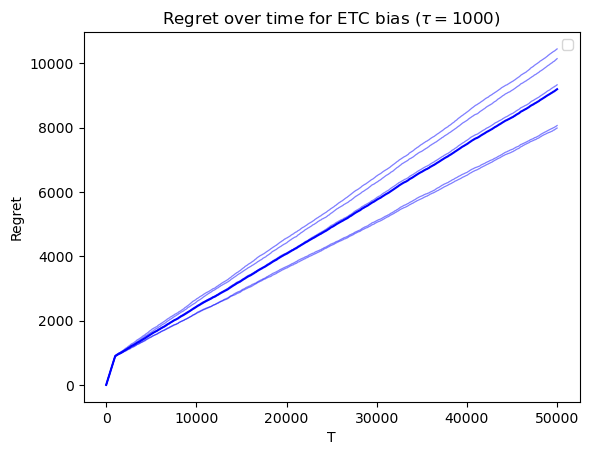

In [11]:
rng = np.random.default_rng(547)
ETC_bias_regrets = []
fig, ax = plt.subplots()

for _ in range(5):
    action_history = ETC_bias(1000, X.copy(), y.copy(), rng)
    regret = np.cumsum(y != action_history)
    ETC_bias_regrets.append(regret)
    ax.plot(range(len(regret)), regret, color="blue", alpha=0.5, linewidth=0.9)
ETC_bias_regrets_avg = np.mean(np.array(ETC_bias_regrets), axis=0)
ax.plot(range(len(ETC_bias_regrets_avg)), ETC_bias_regrets_avg, color="blue")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title(r"Regret over time for ETC bias ($\tau = 1000$)")
ax.legend()
fig.show()

## Follow-The-Leader

In [12]:
def FTL(tau, X, y, rng):
    T = len(y)
    action_history = np.zeros(T, dtype=int)
    actions = rng.choice(10, tau, replace=True)
    action_history[:tau] = actions

    R_t = (action_history[:tau-1] == y[:tau-1]).astype(int)
    C_t = X[:tau-1]
    A_t = np.zeros((tau-1, 10))
    A_t[np.arange(tau-1), action_history[:tau-1]] = 1
    Phi_t = np.einsum("ij,ik->ijk", C_t, A_t).reshape(tau-1, -1)

    V_t = Phi_t.T @ Phi_t
    V_t_inv = np.linalg.inv(V_t)
    S_t = (Phi_t.T @ R_t).reshape(-1, 1)
    
    for t in range(tau, T):
        r_t = (y[t-1] == action_history[t-1])
        e_t = np.zeros(10, dtype=int)
        e_t[action_history[t-1]] = 1
        phi_t = np.outer(X[t], e_t).reshape(-1, 1)
        V_t += phi_t @ phi_t.T
        V_t_inv -= (V_t_inv @ phi_t @ phi_t.T @ V_t_inv) / (1 + phi_t.T @ V_t_inv @ phi_t)
        S_t += phi_t * r_t

        theta_hat = V_t_inv @ S_t

        C_t = np.repeat(X[[t]], repeats=10, axis=0)
        A_t = np.eye(10)
        Phi = np.einsum("ij,ik->ijk", C_t, A_t).reshape(10, -1)
        a_t = np.argmax(Phi @ theta_hat)
        action_history[t] = a_t

    return action_history

c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


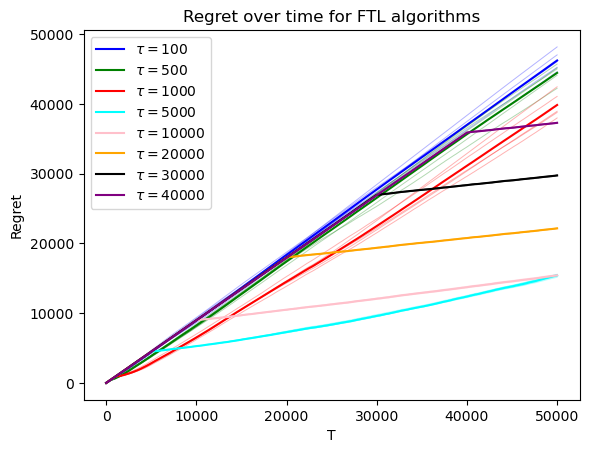

In [13]:
rng = np.random.default_rng(547)

color = ["blue", "green", "red", "cyan", "pink", "orange", "black", "purple"]
tau_range = [100, 500, 1000, 5000, 10000, 20000, 30000, 40000]

fig, ax = plt.subplots()
for i in range(len(tau_range)):
    tau = tau_range[i]
    regrets = []
    for _ in range(5):
        action_history = FTL(tau, X.copy(), y.copy(), rng)
        regret = np.cumsum(y != action_history)
        regrets.append(regret)
        ax.plot(range(len(regret)), regret, color=color[i], alpha=0.3, linewidth=0.7)
    regert_avg = np.mean(np.array(regrets), axis=0)
    ax.plot(range(len(regert_avg)), regert_avg, color=color[i], label=rf"$\tau = {tau}$")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for FTL algorithms")
ax.legend()
fig.show()

From the plot above, we should select $\tau = 10000$ for FTL.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


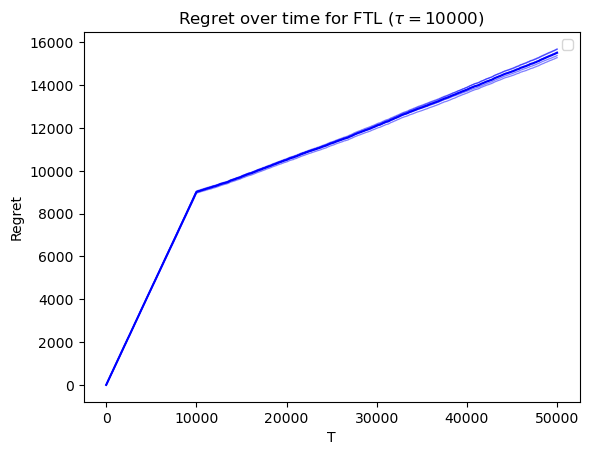

In [14]:
rng = np.random.default_rng(547)
FTL_regrets = []
fig, ax = plt.subplots()

for _ in range(5):
    action_history = FTL(10000, X.copy(), y.copy(), rng)
    regret = np.cumsum(y != action_history)
    FTL_regrets.append(regret)
    ax.plot(range(len(regret)), regret, color="blue", alpha=0.5, linewidth=0.9)
FTL_regrets_avg = np.mean(np.array(FTL_regrets), axis=0)
ax.plot(range(len(FTL_regrets_avg)), FTL_regrets_avg, color="blue")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title(r"Regret over time for FTL ($\tau = 10000$)")
ax.legend()
fig.show()

## LinUCB

In [15]:
def LinUCB(X, y):

    T = len(y)
    d = X.shape[1]
    action_history = np.zeros(T, dtype=int)

    c = 1
    delta = 1 / T
    V_t = np.eye(10 * d)
    V_t_inv = np.eye(10 * d)
    S_t = np.zeros(10 * d).reshape(-1, 1)

    for t in range(T):
        beta_t = c * np.sqrt(10 * d) + np.sqrt(2 * np.log(1 / delta) + np.log(np.linalg.det(V_t + np.eye(10 * d))))
        theta_t = V_t_inv @ S_t
        UCBs = np.zeros(10)
        for a in range(10):
            e_a = np.zeros(10)
            e_a[a] = 1
            phi_a = np.outer(X[t], e_a).reshape(-1)
            UCBs[a] = theta_t.T @ phi_a + beta_t * np.sqrt(phi_a.T @ V_t_inv @ phi_a)
        a_t = np.argmax(UCBs)
        action_history[t] = a_t
        e_t = np.zeros(10)
        e_t[a_t] = 1
        phi_t = np.outer(X[t], e_t).reshape(-1, 1)
        r_t = (y[t] == a_t)
        V_t += phi_t @ phi_t.T
        V_t_inv -=  (V_t_inv @ phi_t @ phi_t.T @ V_t_inv) / (1 + phi_t.T @ V_t_inv @ phi_t)
        S_t += phi_t * r_t
    
    return action_history

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


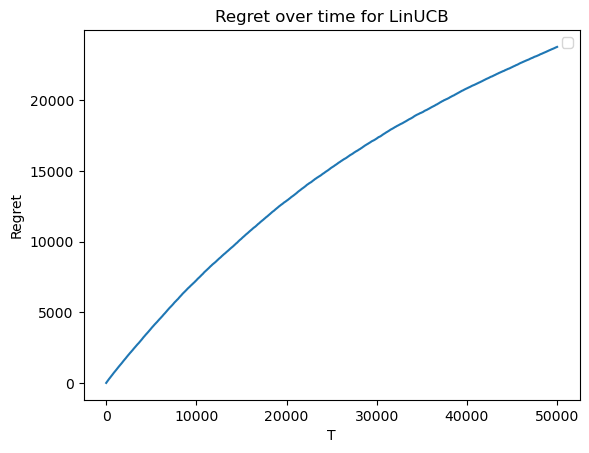

In [16]:
fig, ax = plt.subplots()

action_history = LinUCB(X.copy(), y.copy())
LinUCB_regret = np.cumsum(y != action_history)
ax.plot(range(len(LinUCB_regret)), LinUCB_regret)

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for LinUCB")
ax.legend()
fig.show()

## Thompson Sampling

In [17]:
def Thompson(X, y, rng):
    d = X.shape[1]
    T = len(y)
    action_history = np.zeros(T, dtype=int)

    # first round
    V_t = np.eye(10 * d)
    V_t_inv = np.eye(10 * d)
    S_t = np.zeros(10 * d).reshape(-1, 1)

    for t in range(T):
        theta_t = V_t_inv @ S_t
        theta_tilde_t = rng.multivariate_normal(theta_t.reshape(-1), V_t_inv)

        C_t = np.repeat(X[[t]], repeats=10, axis=0)
        A_t = np.eye(10)
        Phi = np.einsum("ij,ik->ijk", C_t, A_t).reshape(10, -1)
        a_t = np.argmax(Phi @ theta_tilde_t)
        action_history[t] = a_t

        e_t = np.zeros(10)
        e_t[a_t] = 1
        phi_t = np.outer(X[t], e_t).reshape(-1, 1)
        r_t = (y[t] == a_t)
        V_t += phi_t @ phi_t.T
        V_t_inv -=  (V_t_inv @ phi_t @ phi_t.T @ V_t_inv) / (1 + phi_t.T @ V_t_inv @ phi_t)
        S_t += phi_t * r_t

    return action_history


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


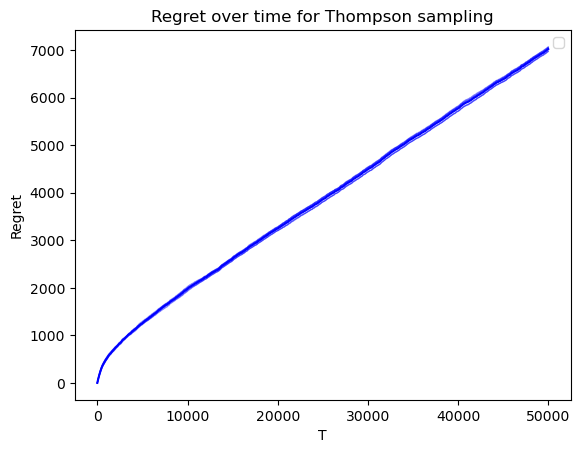

In [18]:
rng = np.random.default_rng(547)
Thompson_regrets = []
fig, ax = plt.subplots()

for _ in range(5):
    action_history = Thompson(X.copy(), y.copy(), rng)
    regret = np.cumsum(y != action_history)
    Thompson_regrets.append(regret)
    ax.plot(range(len(regret)), regret, color="blue", alpha=0.5, linewidth=0.9)
Thompson_regrets_avg = np.mean(np.array(Thompson_regrets), axis=0)
ax.plot(range(len(Thompson_regrets_avg)), Thompson_regrets_avg, color="blue")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
ax.set_title("Regret over time for Thompson sampling")
ax.legend()
fig.show()

## All the algorithms

c:\Users\Wenhao\miniconda3\envs\cse-541\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


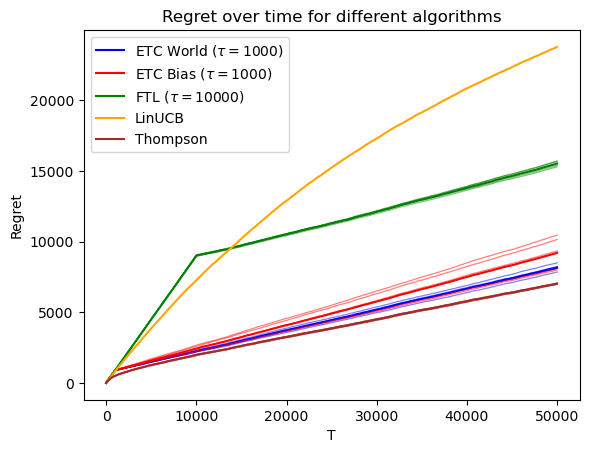

In [19]:
fig, ax = plt.subplots()

for regret in ETC_world_regrets:
    ax.plot(range(len(regret)), regret, color="blue", alpha=0.5, linewidth=0.9)
ax.plot(range(len(ETC_world_regrets_avg)), ETC_world_regrets_avg, color="blue", label=r"ETC World ($\tau = 1000$)")

for regret in ETC_bias_regrets:
    ax.plot(range(len(regret)), regret, color="red", alpha=0.5, linewidth=0.9)
ax.plot(range(len(ETC_bias_regrets_avg)), ETC_bias_regrets_avg, color="red", label=r"ETC Bias ($\tau = 1000$)")

for regret in FTL_regrets:
    ax.plot(range(len(regret)), regret, color="green", alpha=0.5, linewidth=0.9)
ax.plot(range(len(FTL_regrets_avg)), FTL_regrets_avg, color="green", label=r"FTL ($\tau = 10000$)")

ax.plot(range(len(LinUCB_regret)), LinUCB_regret, color="orange", label=r"LinUCB")

for regret in Thompson_regrets:
    ax.plot(range(len(regret)), regret, color="brown", alpha=0.5, linewidth=0.9)
ax.plot(range(len(Thompson_regrets_avg)), Thompson_regrets_avg, color="brown", label=r"Thompson")

ax.set_xlabel("T")
ax.set_ylabel("Regret")
# ax.set_yscale("log")
ax.legend()
ax.set_title("Regret over time for different algorithms")
ax.legend()
fig.show()